In [1]:
# Importações necessárias
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


c:\Users\rodri\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
c:\Users\rodri\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Leitura do dataset
df = pd.read_csv("Dmoz-sports.csv")
df = df[['text', 'class']]

In [3]:
#  Visualização do dataset
df.groupby('class').count()

,text
class,
Baseball,500
Basketball,500
Bowling,500
Cricket,500
Cycling,500
Equestrian,500
Fencing,500
Flying,500
Football,500


In [4]:
# Divisão os dados em treino (70%), validação (10%) e teste (20%)
temp_texts, test_texts, temp_labels, test_labels = train_test_split(
    df['text'], df['class'], test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.125, random_state=42)  # 10% validação (0.125 * 0.8 = 0.1 total)

In [5]:
# Criação de um mapeamento das classes para números
label_map = {label: idx for idx, label in enumerate(df['class'].unique())}
train_labels = train_labels.map(label_map)
val_labels = val_labels.map(label_map)
test_labels = test_labels.map(label_map)

In [6]:
# Tokenização com BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# Tokenizar os textos
def tokenize_texts(texts):
    return tokenizer(list(texts), truncation=True, padding=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)


In [8]:
# Converter para tensores
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
val_labels = torch.tensor(val_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

In [9]:
# Criar Dataset personalizado
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [10]:
# Criação DataLoaders
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)
test_dataset = TextDataset(test_encodings, test_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [11]:
# Carregar o modelo BERT para classificação
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_map))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
# Configurar otimizador e função de perda
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

c:\Users\rodri\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# Loop de treinamento
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        optimizer.zero_grad()
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        loss = loss_fn(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

print("Treinamento concluído!")

C:\Users\rodri\AppData\Local\Temp\ipykernel_9092\3900368064.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)


Epoch 1, Loss: 0.8195
Epoch 2, Loss: 0.2813
Epoch 3, Loss: 0.1803
Treinamento concluído!


In [14]:
# Avaliação do modelo
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels)


C:\Users\rodri\AppData\Local\Temp\ipykernel_9092\3900368064.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)


In [15]:
# Calcular métricas
accuracy = accuracy_score(true_labels, predictions)
f1_micro = f1_score(true_labels, predictions, average='micro')
f1_macro = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)


In [16]:
# Exibir resultados
print(f"Acurácia: {accuracy:.4f}")
print(f"F1-score (Micro): {f1_micro:.4f}")
print(f"F1-score (Macro): {f1_macro:.4f}")


Acurácia: 0.9174
F1-score (Micro): 0.9174
F1-score (Macro): 0.9188


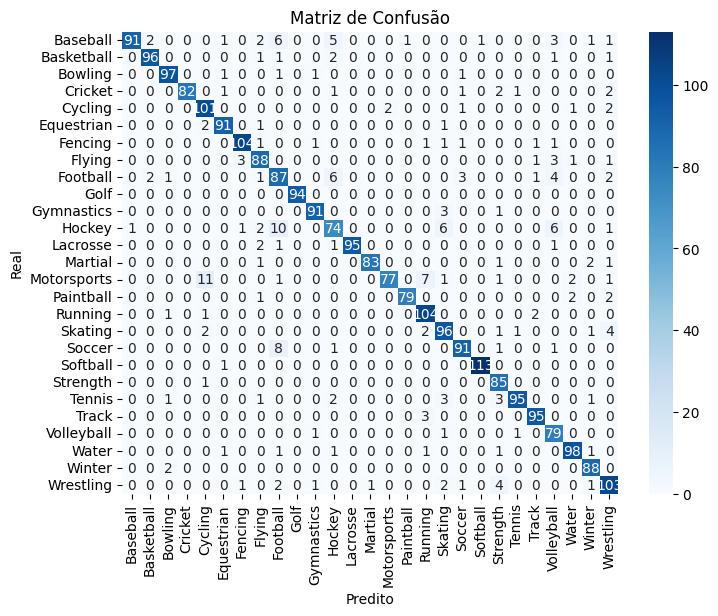

In [17]:
# Plotar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()
